# Variational AutoEncoder


### load image

Image is from CeleA.

In [1]:
import os

os.environ["CUDA_VISIBLE_DEVICES"] = "1"
import time


import skimage.io as img_io
import numpy as np



from matplotlib import pyplot as plt

In [2]:
data_root = "data"
train_path = os.path.join( data_root , "train" )
test_path = os.path.join( data_root , "test" )

train_attribute = np.genfromtxt( train_path+".csv" , delimiter="," , skip_header=0 , dtype="str")
test_attribute = np.genfromtxt( test_path+".csv" , delimiter="," , skip_header=0 , dtype="str")


attr = train_attribute[0,1::]
print("Attribute : ")
print(" , ".join(attr[1:8]))
print(" , ".join(attr[8::]))



Attribute : 
Big_Lips , Black_Hair , Blond_Hair , Brown_Hair , Heavy_Makeup , High_Cheekbones , Male
Mouth_Slightly_Open , Smiling , Straight_Hair , Wavy_Hair , Wearing_Lipstick


In [3]:
train_id = train_attribute[1:,0]
train_attribute = train_attribute[1:,1::].astype("float")

test_id = test_attribute[1:,0]
test_attribute = test_attribute[1:,1::].astype("float")


In [4]:
## load image
train_img = []
for f in train_id:
    train_img.append( img_io.imread( os.path.join( train_path , f ) ) )
    

test_img = []
for f in test_id:
    test_img.append( img_io.imread( os.path.join( test_path , f ) ) )

train_img = np.array(train_img).astype("float")
test_img = np.array(test_img).astype("float")
    


print("Shape of training data :" , train_img.shape)
print("Shape of testing data  :" , test_img.shape)

Shape of training data : (40000, 64, 64, 3)
Shape of testing data  : (2621, 64, 64, 3)


In [5]:
len(os.listdir(test_path))

2621

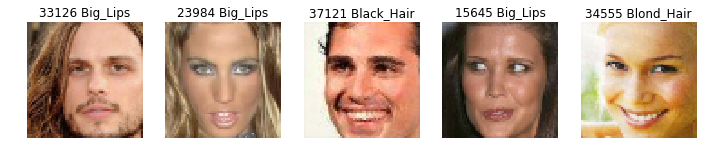

In [6]:
k = 5
idx = np.random.choice(40000 , size=k)

fig = plt.figure(figsize=(2*k+2,3))
for i,img_name in enumerate( idx ):
    ax = fig.add_subplot( 1,k , i+1 )
    ax.imshow( train_img[img_name].astype("int") )
    ax.axis("off")
    a = np.argmax(train_attribute[img_name])
    
    ax.set_title(str(img_name)+" "+attr[a])
plt.show()


In [7]:
processing_input = lambda x : (x/255-0.5)*2
inverse_processing = lambda x : (x/2+0.5)*255

In [8]:
train_data = processing_input(train_img)

### Build Model

In [1]:
import tensorflow as tf

from keras.models import Model , load_model
from keras.layers import Input , BatchNormalization , Dense
from keras.layers import Conv2D , Conv2DTranspose , MaxPooling2D , AveragePooling2D
from keras.layers import Flatten , Reshape , Lambda , Add , Multiply

from keras.callbacks import EarlyStopping , ModelCheckpoint
from keras import metrics

from keras import optimizers as opt
from keras import backend as K

/home/derricksu/Envs/py36_MLDS/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [10]:
tf.reset_default_graph()
gpu_opt = tf.ConfigProto(gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=0.95 , allow_growth=True) 
                             ,device_count={'GPU': 1})
sess = tf.Session(config=gpu_opt)
K.set_session(sess)

In [2]:
code_dim = 1024

x = Input( shape=[64,64,3] )
guassian_sample=Input( shape=[code_dim] )
## Encoder
conv_1 = Conv2D( 64 , [5,5] , strides=[1,1] , activation="relu")(x)
conv_1 = Conv2D( 96 , [3,3] , strides=[1,1] , activation="relu")(conv_1)
block_1 = AveragePooling2D( [3,3] , strides=[2,2])(conv_1)
# block_1 shape is [28,28,96]

conv_2 = BatchNormalization()(block_1)
conv_2 = Conv2D( 96 , [3,3] , strides=[1,1], activation="relu")(conv_2)
conv_2 = Conv2D( 128 , [3,3] , strides=[1,1], activation="relu")(conv_2)
block_2 = MaxPooling2D([3,3] , strides=[2,2])(conv_2)
# block_2 shape is [11,11,128]

conv_3 = BatchNormalization()(block_2)
conv_3 = Conv2D( 128 , [3,3] , strides=[1,1], activation="relu")(conv_3)
conv_3 = Conv2D( 256 , [1,1] , strides=[1,1], activation="relu")(conv_3)
conv_3 = Conv2D( 256 , [3,3] , strides=[1,1], activation="relu")(conv_3)
block_3 = AveragePooling2D([2,2] , strides=[1,1])(conv_3)
# block_3 shape is [6,6,256]

conv_4 = BatchNormalization()(block_3)
conv_4 = Conv2D(512 , [3,3] , strides=[2,2], activation="relu")(conv_4)
encoder_out = Flatten()(Conv2D( 2048 , [2,2] , strides=[1,1] , activation="relu")(conv_4))


z_mean = Dense(code_dim , activation=None , name="z_mean")(encoder_out)
z_log_var = Dense(code_dim , activation="relu" , name="z_log_var" )(encoder_out)

# def sampling(args):
#     z_mean, z_log_var = args
#     epsilon = K.random_normal(shape=(K.shape(z_mean)[0], code_dim),
#                               mean=0., stddev=1.0)
#     return z_mean + K.exp(z_log_var) * epsilon

# note that "output_shape" isn't necessary with the TensorFlow backend
# so you could write `Lambda(sampling)([z_mean, z_log_var])
sampling = Lambda(lambda x : x[0]+ K.exp(0.5*x[1])*K.random_normal(shape=(K.shape(x[1]))), output_shape=(code_dim,)
                 ,name="sampling")
z = sampling([z_mean, z_log_var])

## Decoder
def decode_latency():
    z = Input(shape=[code_dim])
    deconv_1 = Dense(2048 , activation="relu")(z)
    deconv_1 = Reshape([1,1,2048])(deconv_1)
    deconv_1 = Conv2DTranspose( 512 , [2,2] , strides=[1,1] , activation="relu")(deconv_1)
    deconv_1 = Conv2DTranspose( 256 , [5,5] , strides=[1,1] , activation="relu")(deconv_1)
    # deconv_1 shape is [6,6,256]

    deconv_2 = BatchNormalization()(deconv_1)
    deconv_2 = Conv2DTranspose( 128 , [6,6] , strides=[2,2] , activation="relu")(deconv_2)
    # deconv_2 shape is [16,16,128]

    deconv_3 = BatchNormalization()(deconv_2)
    deconv_3 = Conv2DTranspose( 64 , [9,9] , strides=[4,4] , padding="same" , activation="relu")(deconv_2)
    out_img = Conv2D(3 , [1,1] , strides=[1,1] , activation="tanh")(deconv_3)
    model = Model( z , out_img , name="reconstruct")
    return model

reconstruct_model = decode_latency()

reconstruct_img = reconstruct_model(z)
## for testing
test_reconstruct_img = reconstruct_model(z_mean)

VAE = Model( x  , reconstruct_img )
VAE_test = Model( x , test_reconstruct_img )

VAE.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 64, 64, 3)    0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 60, 60, 64)   4864        input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 58, 58, 96)   55392       conv2d_1[0][0]                   
__________________________________________________________________________________________________
average_pooling2d_1 (AveragePoo (None, 28, 28, 96)   0           conv2d_2[0][0]                   
__________________________________________________________________________________________________
batch_norm

In [3]:
from keras.utils import plot_model

In [4]:
plot_model(VAE , "VAE.png" , show_shapes=True)
plot_model(reconstruct_model , "decoder.png", show_shapes=True)


In [12]:
# Compute VAE loss

# xent_loss = K.sum(K.sum(metrics.mse(x , reconstruct_img ) ,axis=-1),axis=-1) /64**2
xent_loss = K.mean(K.square(K.flatten(x)-K.flatten(reconstruct_img)) ,axis=-1 )
kl_loss = - 0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
vae_loss = K.mean(xent_loss + 5e-5*kl_loss)
VAE.add_loss(vae_loss)


In [13]:
decay_policy = tf.train.exponential_decay(2e-4 , decay_rate=0.9 , decay_steps=4000 , global_step=1000)
VAE.compile( optimizer=opt.RMSprop(decay_policy) )
# VAE.compile( optimizer="Adam" )

/home/derricksu/Envs/py36_MLDS/lib/python3.6/site-packages/ipykernel_launcher.py:2: UserWarning: Output "reconstruct" missing from loss dictionary. We assume this was done on purpose, and we will not be expecting any data to be passed to "reconstruct" during training.
  


In [ ]:
history = VAE.fit( train_data , epochs=500 , batch_size=200 , validation_split=0.05 )

Train on 38000 samples, validate on 2000 samples
Epoch 1/500
38000/38000 [==============================] - 39s 1ms/step - loss: 0.1431 - val_loss: 0.1256
Epoch 2/500
38000/38000 [==============================] - 36s 938us/step - loss: 0.1047 - val_loss: 0.1018
Epoch 3/500
38000/38000 [==============================] - 36s 944us/step - loss: 0.0937 - val_loss: 0.0926
Epoch 4/500
38000/38000 [==============================] - 36s 944us/step - loss: 0.0856 - val_loss: 0.0826
Epoch 5/500
38000/38000 [==============================] - 36s 949us/step - loss: 0.0809 - val_loss: 0.0891
Epoch 6/500
38000/38000 [==============================] - 36s 946us/step - loss: 0.0769 - val_loss: 0.0792
Epoch 7/500
38000/38000 [==============================] - 36s 948us/step - loss: 0.0743 - val_loss: 0.0790
Epoch 8/500
38000/38000 [==============================] - 36s 948us/step - loss: 0.0721 - val_loss: 0.0748
Epoch 9/500
38000/38000 [==============================] - 36s 949us/step - loss: 0.0706 

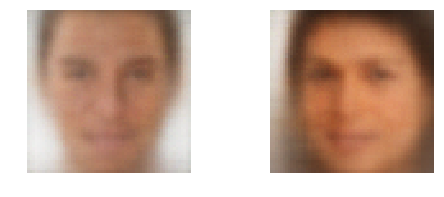

In [38]:
i=15
test1 = VAE_test.predict(train_data[i:i+2])

fig = plt.figure(figsize=(8,3))
for k in range(2):
    ax = fig.add_subplot(1,2,k+1)
    ax.imshow( inverse_processing(test1[k]).astype("int") )
    ax.axis("off")
    
plt.show()

In [71]:


n_epoch = 500
n_batch = 200

n_step = train_data.shape[0]//n_batch

r_index = np.arange( train_data.shape[0] )
history = []
step_kl_loss = []
step_xmse_loss = []
for e in range(n_epoch):
    start_time = time.time()
    np.random.shuffle( r_index )
    data_x = train_data[r_index]
    start = 0
    print( "Epoch {0:4d}/{1}".format( e+1 , n_epoch ) )
    for step in range(n_step):
        print( "[{0:-<30}]".format( "*"*((step+1)*30//n_batch) ) , end="\r" )
        batch_x = data_x[start:start+n_batch]
#         g = np.random.randn( n_batch,code_dim )
        
        VAE.train_on_batch(batch_x ,None )
        history.append(VAE.evaluate(batch_x , None , verbose=0 ))
        step_kl_loss.append(compute_kl.predict(batch_x) )
        step_xmse_loss.append(compute_mse.predict(batch_x) )
    
    l = VAE.evaluate([data_x[0:1000]] , None , verbose=0 )
    
    print("[{0:-<30}] loss: {1:.5f}  time: {2:.1f}".format( "*"*((step+1)*30//n_batch) , l , time.time()-start_time))
        
    

/home/derricksu/Envs/py36_MLDS/lib/python3.6/site-packages/ipykernel_launcher.py:1: UserWarning: Output "conv2d_30" missing from loss dictionary. We assume this was done on purpose, and we will not be expecting any data to be passed to "conv2d_30" during training.
  """Entry point for launching an IPython kernel.


Epoch    1/500


InvalidArgumentError: Incompatible shapes: [200,64,64] vs. [200]
	 [[Node: add_26 = Add[T=DT_FLOAT, _device="/job:localhost/replica:0/task:0/device:GPU:0"](mul_13, mul_14)]]
	 [[Node: loss_9/add/_1661 = _Recv[client_terminated=false, recv_device="/job:localhost/replica:0/task:0/device:CPU:0", send_device="/job:localhost/replica:0/task:0/device:GPU:0", send_device_incarnation=1, tensor_name="edge_2686_loss_9/add", tensor_type=DT_FLOAT, _device="/job:localhost/replica:0/task:0/device:CPU:0"]()]]

Caused by op 'add_26', defined at:
  File "/usr/local/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/usr/local/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/derricksu/Envs/py36_MLDS/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/home/derricksu/Envs/py36_MLDS/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/home/derricksu/Envs/py36_MLDS/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 486, in start
    self.io_loop.start()
  File "/home/derricksu/Envs/py36_MLDS/lib/python3.6/site-packages/tornado/platform/asyncio.py", line 112, in start
    self.asyncio_loop.run_forever()
  File "/usr/local/lib/python3.6/asyncio/base_events.py", line 421, in run_forever
    self._run_once()
  File "/usr/local/lib/python3.6/asyncio/base_events.py", line 1431, in _run_once
    handle._run()
  File "/usr/local/lib/python3.6/asyncio/events.py", line 145, in _run
    self._callback(*self._args)
  File "/home/derricksu/Envs/py36_MLDS/lib/python3.6/site-packages/tornado/platform/asyncio.py", line 102, in _handle_events
    handler_func(fileobj, events)
  File "/home/derricksu/Envs/py36_MLDS/lib/python3.6/site-packages/tornado/stack_context.py", line 276, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/derricksu/Envs/py36_MLDS/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 450, in _handle_events
    self._handle_recv()
  File "/home/derricksu/Envs/py36_MLDS/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 480, in _handle_recv
    self._run_callback(callback, msg)
  File "/home/derricksu/Envs/py36_MLDS/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 432, in _run_callback
    callback(*args, **kwargs)
  File "/home/derricksu/Envs/py36_MLDS/lib/python3.6/site-packages/tornado/stack_context.py", line 276, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/derricksu/Envs/py36_MLDS/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 283, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/home/derricksu/Envs/py36_MLDS/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 233, in dispatch_shell
    handler(stream, idents, msg)
  File "/home/derricksu/Envs/py36_MLDS/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 399, in execute_request
    user_expressions, allow_stdin)
  File "/home/derricksu/Envs/py36_MLDS/lib/python3.6/site-packages/ipykernel/ipkernel.py", line 208, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/home/derricksu/Envs/py36_MLDS/lib/python3.6/site-packages/ipykernel/zmqshell.py", line 537, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/home/derricksu/Envs/py36_MLDS/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2728, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/home/derricksu/Envs/py36_MLDS/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2850, in run_ast_nodes
    if self.run_code(code, result):
  File "/home/derricksu/Envs/py36_MLDS/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2910, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-70-2b52fe89fa97>", line 5, in <module>
    vae_loss = K.mean(xent_loss + kl_loss)
  File "/home/derricksu/Envs/py36_MLDS/lib/python3.6/site-packages/tensorflow/python/ops/math_ops.py", line 934, in binary_op_wrapper
    return func(x, y, name=name)
  File "/home/derricksu/Envs/py36_MLDS/lib/python3.6/site-packages/tensorflow/python/ops/gen_math_ops.py", line 183, in add
    "Add", x=x, y=y, name=name)
  File "/home/derricksu/Envs/py36_MLDS/lib/python3.6/site-packages/tensorflow/python/framework/op_def_library.py", line 787, in _apply_op_helper
    op_def=op_def)
  File "/home/derricksu/Envs/py36_MLDS/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 3271, in create_op
    op_def=op_def)
  File "/home/derricksu/Envs/py36_MLDS/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 1650, in __init__
    self._traceback = self._graph._extract_stack()  # pylint: disable=protected-access

InvalidArgumentError (see above for traceback): Incompatible shapes: [200,64,64] vs. [200]
	 [[Node: add_26 = Add[T=DT_FLOAT, _device="/job:localhost/replica:0/task:0/device:GPU:0"](mul_13, mul_14)]]
	 [[Node: loss_9/add/_1661 = _Recv[client_terminated=false, recv_device="/job:localhost/replica:0/task:0/device:CPU:0", send_device="/job:localhost/replica:0/task:0/device:GPU:0", send_device_incarnation=1, tensor_name="edge_2686_loss_9/add", tensor_type=DT_FLOAT, _device="/job:localhost/replica:0/task:0/device:CPU:0"]()]]


In [13]:
test1 = AE.predict( train_data[0:1] )
test1 = inverse_processing(test1)

In [15]:
test1.shape

(1, 64, 64, 3)

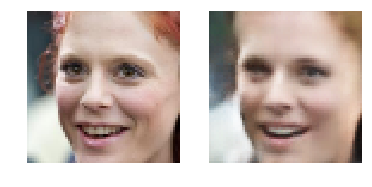

In [22]:
fig , (ax1 , ax2) = plt.subplots(1,2)

ax1.imshow(train_img[0].astype("int"))
ax1.axis("off")

ax2.imshow(test1.reshape(64,64,3).astype("int"))
ax2.axis("off")

plt.show()